In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from environment.single_family_home import SingleFamilyHome

In [3]:
env = SingleFamilyHome()
env.reset()

({'carbon_intensity': array([40.17], dtype=float32),
  'household_energy_demand': array([0.], dtype=float32),
  'rooftop_solar_generation': array([-0.303], dtype=float32),
  'energy_storage_system_charge': array([0.], dtype=float32),
  'flexible_demand_schedule': array([6.6780605], dtype=float32),
  'tcl_indoor_temperature': array([20.], dtype=float32),
  'day_of_year': array([1.], dtype=float32),
  'hour_of_day': array([0.], dtype=float32),
  'solar_irradiation': array([0.], dtype=float32),
  'solar_elevation': array([0.], dtype=float32),
  'temperature': array([12.455], dtype=float32),
  'wind_speed': array([8.29], dtype=float32)},
 {})

# Static Components Figure

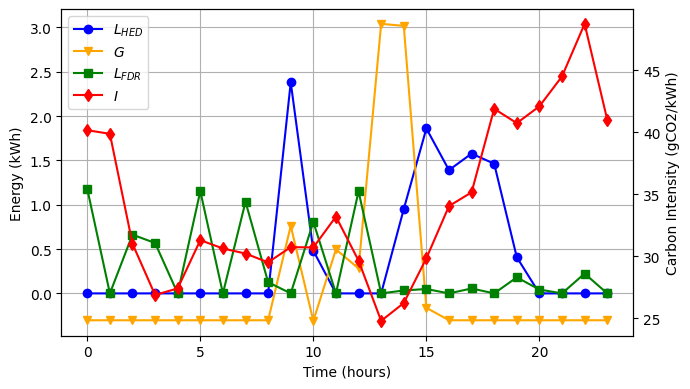

In [8]:

fig, ax = plt.subplots(figsize=(7, 4))
line1, = ax.plot(env.hed.episode.values[:24], label=r"$L_{HED}$", marker='o', color='blue')
line2, = ax.plot(env.rsa.episode.values[:24], label=r"$G$", marker='v', color='orange')
line3, = ax.plot(env.fdr.episode.values[:24], label=r"$L_{FDR}$", marker='s', color='green')
ax2 = ax.twinx()
line4, = ax2.plot(env.ees.episode.values[:24], label="$I$", marker='d', color='red')

# Create a list of lines and labels
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]

# Create the legend box
ax.legend(lines, labels, loc='upper left')

# Set labels for the x and y axes
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Energy (kWh)')
ax2.set_ylabel('Carbon Intensity (gCO2/kWh)')


# Add a grid to the plot
ax.grid(True)

# Adjust subplot parameters
plt.tight_layout()

# Show the plot
plt.show()